In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Patch
from matplotlib import cm

In [11]:
# Clustering Evaluation Function
def evaluate_clustering(X, labels, n_clusters, ax=None, title_suffix=""):
    """
    Evaluate a clustering model using silhouette scores and the Davies-Bouldin index.

    Parameters:
    X (ndarray): Feature matrix.
    labels (array-like): Cluster labels assigned to each sample.
    n_clusters (int): The number of clusters in the model.
    ax: The subplot axes to plot on.
    title_suffix (str): Optional suffix for plot titlec

    Returns:
    None: Displays silhoutte scores and a silhouette plot.
    """
    if ax is None:
        ax = plt.gca()  # Get the current axis if none is provided

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Plot silhouette analysis on the provided axis
    unique_labels = np.unique(labels)
    colormap = cm.tab10
    color_dict = {label: colormap(float(label) / n_clusters) for label in unique_labels}
    y_lower = 10
    for i in unique_labels:
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = color_dict[i]
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(
        f"Silhouette Score for {title_suffix} \n"
        + f"Average Silhouette: {silhouette_avg:.2f}"
    )
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim([-0.25, 1])  # Set the x-axis range to [0, 1]

    ax.set_yticks([])

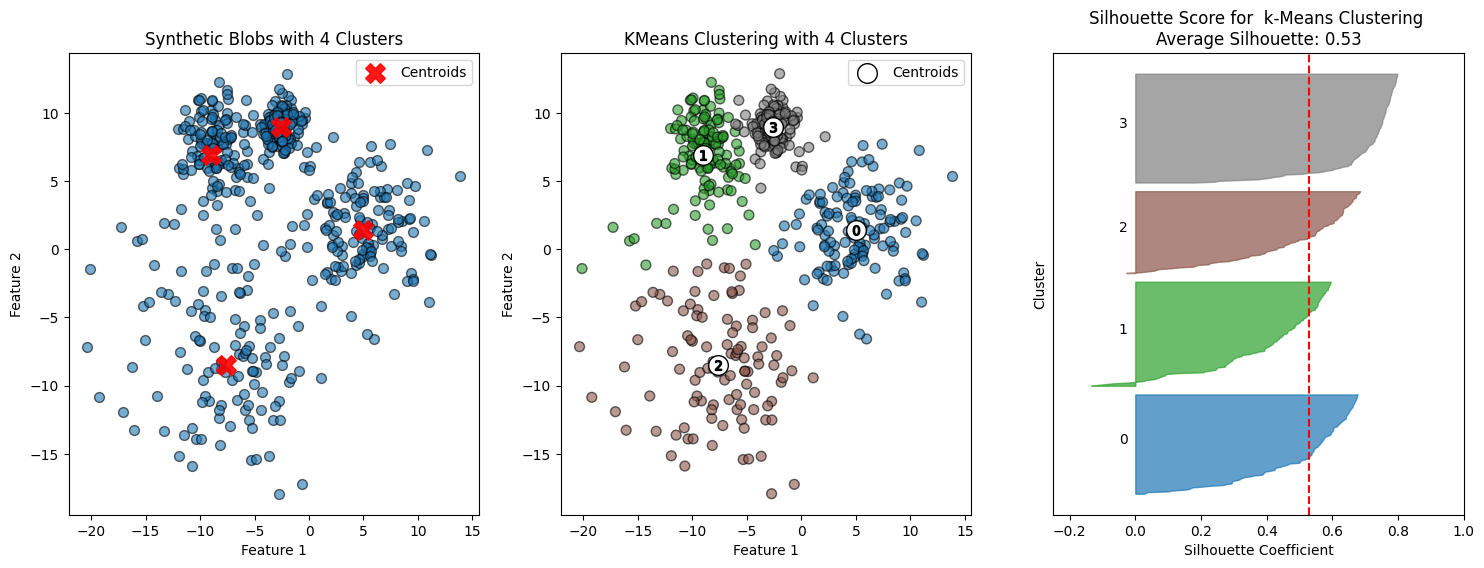

In [12]:
# Create synthetic data with four blobs to expriment with k-means clustering

X, y = make_blobs(
    n_samples=500, n_features=2, centers=4, cluster_std=[1, 3, 5, 2], random_state=42
)

# Apply KMeans Clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X)

colormap = cm.tab10

# Plot the blobs
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolors="k")
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c="red",
    s=200,
    marker="X",
    alpha=0.9,
    label="Centroids",
)
plt.title(f"Synthetic Blobs with {n_clusters} Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Plot the clustering result
# Create colors based on the predicted labels
colors = colormap(y_kmeans.astype(float) / n_clusters)

plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolors="k")

# Label the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolors="k",
    label="Centroids",
)
# Label the custer number
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.title(f"KMeans Clustering with {n_clusters} Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Evaluate the clustering
plt.subplot(1, 3, 3)
evaluate_clustering(X, y_kmeans, n_clusters, title_suffix=" k-Means Clustering")
plt.show()

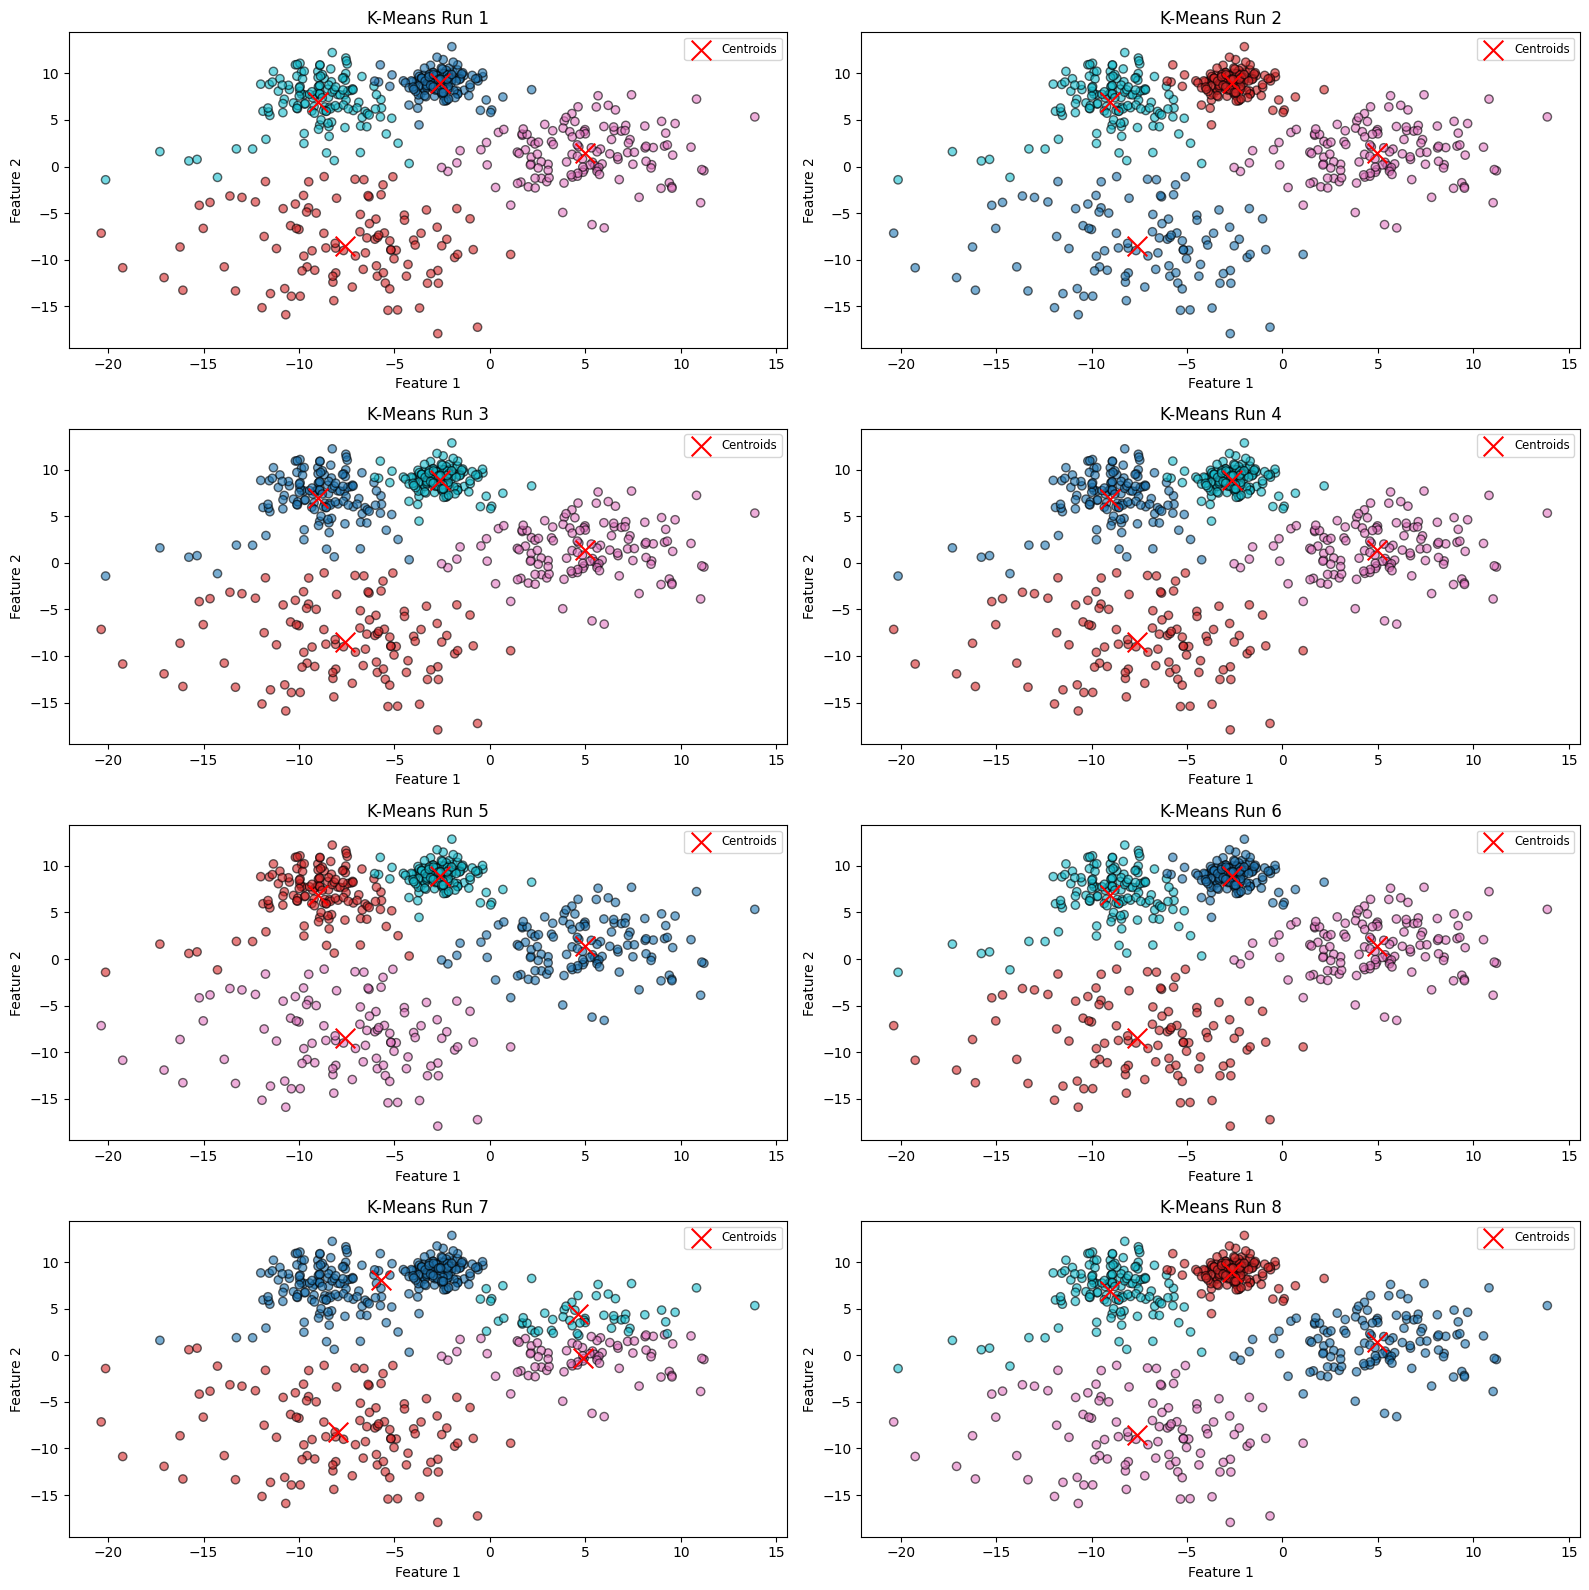

Run 1: Inertia=7633.51
Run 2: Inertia=7633.51
Run 3: Inertia=7633.51
Run 4: Inertia=7633.68
Run 5: Inertia=7633.51
Run 6: Inertia=7633.68
Run 7: Inertia=9826.66
Run 8: Inertia=7633.51


In [13]:
# Number of runs for k-means with different random states
n_runs = 8
inertia_values = []

# Calculate number of rows and columns needed for subplots
n_cols = 2  # Number of columns
n_rows = -(-n_runs // n_cols)  # Ceil division to determine rows
plt.figure(figsize=(16, 16))  # Adjust the figure size for better visualization

# Run K-Means multiple times with different random states
for i in range(n_runs):
    kmeans = KMeans(n_clusters=4, random_state=None)  # Use the default `n_init`
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

    # Plot the clustering result
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(
        X[:, 0], X[:, 1], c=kmeans.labels_, cmap="tab10", alpha=0.6, edgecolor="k"
    )
    plt.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        c="red",
        s=200,
        marker="x",
        label="Centroids",
    )
    plt.title(f"K-Means Run {i + 1}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()

# Print inertia values
for i, inertia in enumerate(inertia_values, start=1):
    print(f"Run {i}: Inertia={inertia:.2f}")

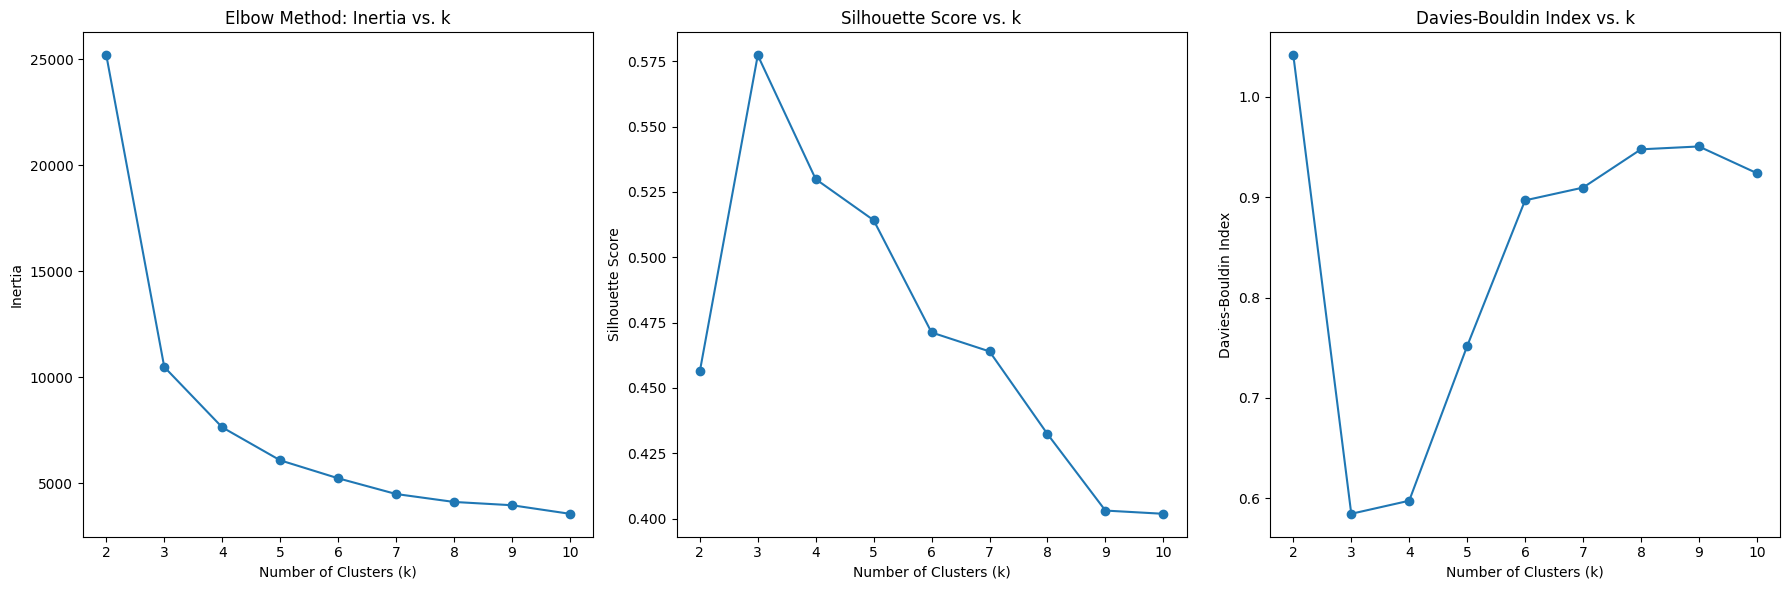

In [16]:
# Range of k values to test
k_values = range(2, 11)

# Store performace metrics
inertia_values = []
silhouette_scores = []
davies_bouldin_indices = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Calculate and store metrics
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, y_kmeans))
    davies_bouldin_indices.append(davies_bouldin_score(X, y_kmeans))

# Plot the inertia values (Elbow Method)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values, marker="o")
plt.title("Elbow Method: Inertia vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

# Plot silhouette scores
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker="o")
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, davies_bouldin_indices, marker="o")
plt.title("Davies-Bouldin Index vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")

plt.tight_layout()
plt.show()